# Excercse MNIST
1. complete the training process
2. Get the MAX accuracy and MIN loss of your final model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics # DNN 系列
from tensorflow.keras.layers import Dense, LSTM,Bidirectional,SimpleRNN,GRU,Activation # RNN系列
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D # CNN系列
from tensorflow.keras.layers import Input,BatchNormalization,AveragePooling2D # ResNet系列
from tensorflow.keras.regularizers import l2 # ResNet系列
from tensorflow import keras # ResNet系列
from tensorflow.keras.models import Model # ResNet系列
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

## Prepare Data

In [4]:
# Load Data from file
with np.load('D:/Record/AI_技術/電腦視覺/醫學影像分析/【基礎班】L2課程檔案/HW_mnist/mnist.npz', allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

# Data shape
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title= "label=" +str(labels[idx])
        if len(prediction)>0:
            title+=",predict="+str(prediction[idx]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

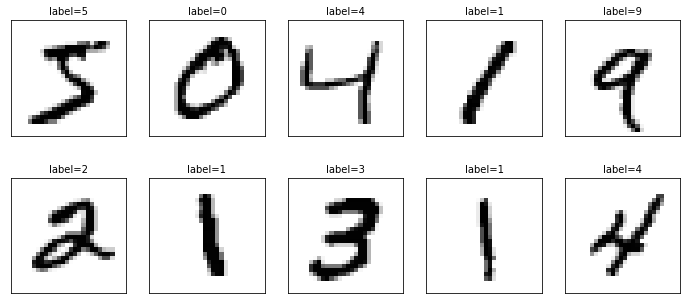

In [6]:
plot_images_labels_prediction(x_train,y_train,[],0,10)

## Define Parameters

In [47]:
# --------------------------------- Data ------------------------------------
num_classes = 10
img_rows, img_cols = x_train.shape[1] , x_train.shape[2] # 定義圖像寬、高
RGB = 1

# --------------------------------- Data Augmentation ------------------------------------
ImageDataGenerator_threshold = False # True/False

ver = ''
if ImageDataGenerator_threshold :
    ver += '.1'

# --------------------------------- Model ------------------------------------
Mode = 4 # 1 for 1-V / 2 for 2-V / 3 for 3-V
Epochs = 60
Batch_size = 128
n = 3 # mode 5、6 for ResNet
Pool_size = 7 # mode 5、6 for ResNet

# --------------------------------- Path ------------------------------------
Path = "D:/Record/AI_技術/電腦視覺/醫學影像分析/【基礎班】L2課程檔案/HW_mnist/"
filepath = Path+"weights-improvement_mode"+str(Mode)+ver+".hdf5" # -{epoch:02d}-{val_acc:.2f}
CSVpath = Path+"result_mode"+str(Mode)+ver+"_Epoch"+str(Epochs)+".csv"
Recordpath = Path+"Recordscore.txt"
ACCpng = Path+"Accuracy_mode"+str(Mode)+ver+"_Epoch"+str(Epochs)+".png"
LOSSpng = Path+"Loss_mode"+str(Mode)+ver+"_Epoch"+str(Epochs)+".png"

## Data Process

In [48]:
# --------------------------------- reshape ------------------------------------
if Mode == 1 : # for DNN
    x_Train_big = x_train.reshape(x_train.shape[0], -1) # Flatten img to a vector
    x_Test = x_test.reshape(x_test.shape[0], -1)
    
elif Mode == 2 : # for RNN Model
    x_Train_big = x_train.reshape(x_train.shape[0], img_rows, img_cols*RGB) # Flatten img to a vector
    x_Test = x_test.reshape(x_test.shape[0], img_rows, img_cols*RGB)
    
elif Mode in [3,4,5,6] : # for CNN Model
    x_Train_big = x_train.reshape(x_train.shape[0], img_rows, img_cols, RGB) # rashape size
    x_Test = x_test.reshape(x_test.shape[0], img_rows, img_cols, RGB)
    input_shape = (img_rows, img_cols, RGB)
    
# --------------------------------- normalization ------------------------------------
# normalization 轉換色彩 0~255 資料為 0~1
x_Train_big = x_Train_big.astype('float32')
x_Test = x_Test.astype('float32')
x_Train_big /= 255
x_Test /= 255

# --------------------------------- split dataset ------------------------------------
''' 因訓練時不知道test data答案，因此額外切出val data作為挑選模型用 '''

x_Train, x_Val, y_Train, y_Val = train_test_split(x_Train_big, y_train, test_size=0.2)
input_shape = x_Train.shape[1:]
print ( x_Train.shape, x_Val.shape, y_Train.shape, y_Val.shape )

# --------------------------------- one hot encoding ------------------------------------
y_Train_OneHot = utils.to_categorical(y_Train, num_classes=num_classes)
y_Val_OneHot = utils.to_categorical(y_Val, num_classes=num_classes)
y_Test_OneHot = utils.to_categorical(y_test, num_classes=num_classes)

(48000, 28, 28, 1) (12000, 28, 28, 1) (48000,) (12000,)


## Build Model

In [49]:
if Mode == 1 : # DNN Model
    # Build model 
    model = models.Sequential()
    model.add(layers.Dense(units=20, activation='relu', input_shape=(img_rows*img_cols*RGB,)))
    model.add(layers.Dense(units=20))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

elif Mode == 2 : # RNN Model
    model = models.Sequential()
    model.add(SimpleRNN(
      batch_input_shape=(None, img_rows,img_cols*RGB), 
      units= 50,
      unroll=True,
    )) 
    model.add(Dense(units=num_classes, kernel_initializer='normal', activation='softmax'))
    
elif Mode == 3 : # CNN Model
    # 建立簡單的線性執行的模型
    model = models.Sequential()
    # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
    model.add(Dropout(0.25))
    # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
    model.add(Flatten())
    # 全連接層: 128個output
    model.add(Dense(128, activation='relu'))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.5
    model.add(Dropout(0.5))
    # 使用 softmax activation function，將結果分類
    model.add(Dense(num_classes, activation='softmax'))

elif Mode == 4 : # VGG
    model =  models.Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, input_shape=(img_rows, img_cols, RGB), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=3, input_shape=(img_rows, img_cols, RGB), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(10, activation='softmax'))

elif Mode in [5,6] : # Resnet v1 & v2
    def resnet_layer(inputs,
                     num_filters=16,
                     kernel_size=3,
                     strides=1,
                     activation='relu',
                     batch_normalization=True,
                     conv_first=True):
        """2D 卷积批量标准化 - 激活栈构建器
        # 参数
            inputs (tensor): 从输入图像或前一层来的输入张量
            num_filters (int): Conv2D 过滤器数量
            kernel_size (int): Conv2D 方形核维度
            strides (int): Conv2D 方形步幅维度
            activation (string): 激活函数名
            batch_normalization (bool): 是否包含批标准化
            conv_first (bool): conv-bn-activation (True) 或
                bn-activation-conv (False)
        # 返回
            x (tensor): 作为下一层输入的张量
        """
        conv = Conv2D(num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=l2(1e-4))

        x = inputs
        if conv_first:
            x = conv(x)
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
        else:
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
            x = conv(x)
        return x

    def resnet_v1(input_shape, depth, num_classes=10):
        """ResNet 版本 1 模型构建器 [a]

        2 x (3 x 3) Conv2D-BN-ReLU 的堆栈
        最后一个 ReLU 在快捷连接之后。
        在每个阶段的开始，特征图大小由具有 strides=2 的卷积层减半（下采样），
        而滤波器的数量加倍。在每个阶段中，这些层具有相同数量的过滤器和相同的特征图尺寸。
        特征图尺寸:
        stage 0: 32x32, 16
        stage 1: 16x16, 32
        stage 2:  8x8,  64
        参数数量与 [a] 中表 6 接近:
        ResNet20 0.27M
        ResNet32 0.46M
        ResNet44 0.66M
        ResNet56 0.85M
        ResNet110 1.7M

        # 参数
            input_shape (tensor): 输入图像张量的尺寸
            depth (int): 核心卷积层的数量
            num_classes (int): 类别数 (CIFAR10 为 10)

        # 返回
            model (Model): Keras 模型实例
        """
        if (depth - 2) % 6 != 0:
            raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
        # 开始模型定义
        num_filters = 16
        num_res_blocks = int((depth - 2) / 6)

        inputs = Input(shape=input_shape)
        x = resnet_layer(inputs=inputs)
        # 实例化残差单元的堆栈
        for stack in range(3):
            for res_block in range(num_res_blocks):
                strides = 1
                if stack > 0 and res_block == 0:  # 第一层但不是第一个栈
                    strides = 2  # downsample
                y = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 strides=strides)
                y = resnet_layer(inputs=y,
                                 num_filters=num_filters,
                                 activation=None)
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    # 线性投影残差快捷键连接，以匹配更改的 dims
                    x = resnet_layer(inputs=x,
                                     num_filters=num_filters,
                                     kernel_size=1,
                                     strides=strides,
                                     activation=None,
                                     batch_normalization=False)
                x = keras.layers.add([x, y])
                x = Activation('relu')(x)
            num_filters *= 2

        # 在顶层加分类器。
        # v1 不在最后一个快捷连接 ReLU 后使用 BN
        x = AveragePooling2D(pool_size=Pool_size)(x) # 7
        y = Flatten()(x)
        outputs = Dense(num_classes,
                        activation='softmax',
                        kernel_initializer='he_normal')(y)

        # 实例化模型。
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def resnet_v2(input_shape, depth, num_classes=10):
        """ResNet 版本 2 模型构建器 [b]

        (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D 的堆栈，也被称为瓶颈层。
        每一层的第一个快捷连接是一个 1 x 1 Conv2D。
        第二个及以后的快捷连接是 identity。
        在每个阶段的开始，特征图大小由具有 strides=2 的卷积层减半（下采样），
        而滤波器的数量加倍。在每个阶段中，这些层具有相同数量的过滤器和相同的特征图尺寸。
        特征图尺寸:
        conv1  : 32x32,  16
        stage 0: 32x32,  64
        stage 1: 16x16, 128
        stage 2:  8x8,  256

        # 参数
            input_shape (tensor): 输入图像张量的尺寸
            depth (int): 核心卷积层的数量
            num_classes (int): 类别数 (CIFAR10 为 10)

        # 返回
            model (Model): Keras 模型实例
        """
        if (depth - 2) % 9 != 0:
            raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
        # 开始模型定义。
        num_filters_in = 16
        num_res_blocks = int((depth - 2) / 9)

        inputs = Input(shape=input_shape)
        # v2 在将输入分离为两个路径前执行带 BN-ReLU 的 Conv2D 操作。
        x = resnet_layer(inputs=inputs,
                         num_filters=num_filters_in,
                         conv_first=True)

        # 实例化残差单元的栈
        for stage in range(3):
            for res_block in range(num_res_blocks):
                activation = 'relu'
                batch_normalization = True
                strides = 1
                if stage == 0:
                    num_filters_out = num_filters_in * 4
                    if res_block == 0:  # first layer and first stage
                        activation = None
                        batch_normalization = False
                else:
                    num_filters_out = num_filters_in * 2
                    if res_block == 0:  # first layer but not first stage
                        strides = 2    # downsample

                # 瓶颈残差单元
                y = resnet_layer(inputs=x,
                                 num_filters=num_filters_in,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=activation,
                                 batch_normalization=batch_normalization,
                                 conv_first=False)
                y = resnet_layer(inputs=y,
                                 num_filters=num_filters_in,
                                 conv_first=False)
                y = resnet_layer(inputs=y,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 conv_first=False)
                if res_block == 0:
                    # 线性投影残差快捷键连接，以匹配更改的 dims
                    x = resnet_layer(inputs=x,
                                     num_filters=num_filters_out,
                                     kernel_size=1,
                                     strides=strides,
                                     activation=None,
                                     batch_normalization=False)
                x = keras.layers.add([x, y])

            num_filters_in = num_filters_out

        # 在顶层添加分类器
        # v2 has BN-ReLU before Pooling
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AveragePooling2D(pool_size=Pool_size)(x) # 7
        y = Flatten()(x)
        outputs = Dense(num_classes,
                        activation='softmax',
                        kernel_initializer='he_normal')(y)

        # 实例化模型。
        model = Model(inputs=inputs, outputs=outputs)
        return model 

    
    if Mode == 5 : # ResNet v1  
        depth = n * 6 + 2
        model = resnet_v1(input_shape=input_shape, depth=depth)

    elif Mode == 6 : # ResNet v2  
        depth = n * 9 + 2
        model = resnet_v2(input_shape=input_shape, depth=depth)
    
    
print(model.summary())

# Setting for training
model.compile(loss=losses.categorical_crossentropy, # loss function : sparse_categorical_crossentropy / categorical_crossentropy / binary_crossentropy
              optimizer='adam', # 'adam' optimizers.SGD()
              metrics=['categorical_accuracy'] # accuracy categorical_accuracy
              )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 7, 7, 128)        

## 資料增強（Data Augmentation）

In [50]:
if ImageDataGenerator_threshold :

    datagen = ImageDataGenerator(
            featurewise_center=False,  # 將整個數據集的均值設為0
            samplewise_center=False,  # 將每個樣本的均值設為0
            featurewise_std_normalization=False,  # 將輸入除以整個數據集的標準差
            samplewise_std_normalization=False,  # 將輸入除以其標準差
            zca_whitening=False,  # 運用 ZCA 白化
            zca_epsilon=1e-06,  # ZCA 白化的 epsilon值
            rotation_range=0,  # 隨機旋轉圖像範圍 (角度, 0 to 180)
            # 隨機水平移動圖像 (總寬度的百分比)
            width_shift_range=0.1,
            # 隨機垂直移動圖像 (總高度的百分比)
            height_shift_range=0.1,
            shear_range=0.,  # 設置隨機裁剪範圍
            zoom_range=0.,  # 設置隨機放大範圍
            channel_shift_range=0.,  # 設置隨機通道切換的範圍
            # 設置填充輸入邊界之外的點的模式
            fill_mode='nearest',
            cval=0.,  # 在 fill_mode = "constant" 時使用的值
            horizontal_flip=True,  # 隨機水平翻轉圖像
            vertical_flip=False,  # 隨機垂直翻轉圖像
            # 設置縮放因子 (在其他轉換之前使用)
            rescale=None,
            # 設置將應用於每一個輸入的函數
            preprocessing_function=None,
            # 圖像數據格式，"channels_first" 或 "channels_last" 之一
            data_format=None,
            # 保留用於驗證的圖像比例（嚴格在0和1之間）
            validation_split=0.0)
    
    # 計算特徵標準化所需的計算量
    # (如果應用 ZCA 白化，則為 std，mean和主成分).
    datagen.fit(x_Train)

## Training

In [20]:
# 定義 ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [21]:
if ver == '':
    logs = model.fit(x_Train, y_Train_OneHot, batch_size=Batch_size, epochs=Epochs, validation_data=(x_Val, y_Val_OneHot), callbacks=callbacks_list)
else:
    logs = model.fit_generator(datagen.flow(x_Train, y_Train_OneHot, batch_size=Batch_size), epochs=Epochs, validation_data=(x_Val, y_Val_OneHot), callbacks=callbacks_list)

Train on 48000 samples, validate on 12000 samples
Epoch 1/60
47872/48000 [============================>.] - ETA: 0s - loss: 0.1852 - categorical_accuracy: 0.9406
Epoch 00001: val_categorical_accuracy improved from -inf to 0.98433, saving model to D:/Record/AI_技術/電腦視覺/醫學影像分析/【基礎班】L2課程檔案/HW_mnist/weights-improvement_mode4.hdf5
48000/48000 [==============================] - 130s 3ms/sample - loss: 0.1849 - categorical_accuracy: 0.9407 - val_loss: 0.0556 - val_categorical_accuracy: 0.9843
Epoch 2/60
47872/48000 [============================>.] - ETA: 0s - loss: 0.0438 - categorical_accuracy: 0.9868
Epoch 00002: val_categorical_accuracy improved from 0.98433 to 0.98567, saving model to D:/Record/AI_技術/電腦視覺/醫學影像分析/【基礎班】L2課程檔案/HW_mnist/weights-improvement_mode4.hdf5
48000/48000 [==============================] - 130s 3ms/sample - loss: 0.0437 - categorical_accuracy: 0.9868 - val_loss: 0.0470 - val_categorical_accuracy: 0.9857
Epoch 3/60
47872/48000 [============================>.] - ETA: 0s -

## History

In [35]:
history = logs.history
val_score = history['val_categorical_accuracy']
max_val_score = max(val_score)
max_val_epochs = val_score.index(max_val_score)+1
print( 'Best val score : ' + str(max_val_score) )
print( 'Best val epoch : ' + str(max_val_epochs) )

Best val score : 0.9935
Best val epoch : 59


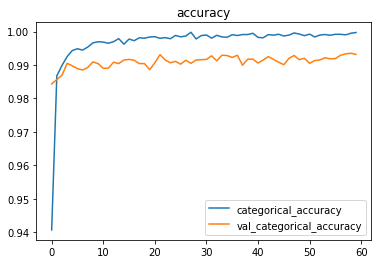

In [36]:
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])
plt.title('accuracy')
plt.savefig(ACCpng)

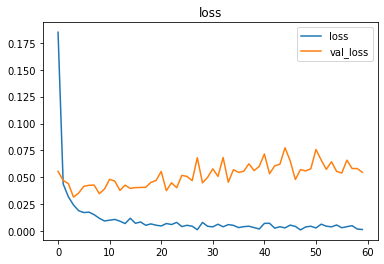

In [24]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.savefig(LOSSpng)

## Load Best Model

In [51]:
# Loads the weights
model.load_weights(filepath)

## Generate file for Kaggle

In [52]:
# predict by your model
predictions = model.predict(x_Test)
predictions = np.argmax(predictions, axis=-1)

df = pd.DataFrame()
df['Id'] = [str(i) for i in range(len(x_Test))]
df['Category'] = predictions
df.to_csv(CSVpath, index=None)
df

,Id,Category
0,0,7
1,1,2
2,2,1
3,3,0
4,4,4
...,...,...
9995,9995,2
9996,9996,3
9997,9997,4
9998,9998,5


## Calculate Score

In [89]:
y_true = np.argmax(y_Test_OneHot, axis=-1) # Ground Truth
y_pred = np.argmax(model.predict(x_Test), axis=-1) # Model prediction
print(y_true.shape, y_pred.shape)

(10000,) (10000,)


In [90]:
# Classification Report
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
label_names = [str(i) for i in range(10)] # ['0' ~  '9']
print(classification_report(y_true, y_pred, target_names=label_names ,digits=5))

              precision    recall  f1-score   support

           0    0.99491   0.99796   0.99643       980
           1    0.99472   0.99648   0.99560      1135
           2    0.99614   0.99903   0.99758      1032
           3    0.99310   0.99703   0.99506      1010
           4    0.99492   0.99695   0.99593       982
           5    0.99439   0.99327   0.99383       892
           6    0.99580   0.99061   0.99320       958
           7    0.99706   0.99125   0.99415      1028
           8    0.99692   0.99692   0.99692       974
           9    0.99404   0.99207   0.99306      1009

    accuracy                        0.99520     10000
   macro avg    0.99520   0.99516   0.99518     10000
weighted avg    0.99520   0.99520   0.99520     10000



In [92]:
# Confusion Matrix: 
# Row: Truth
# Column: Prediction
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
print(confusion_matrix(y_true, y_pred))

[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1131    0    1    0    2    1    0    0    0]
 [   0    0 1031    0    0    0    0    1    0    0]
 [   0    0    0 1007    0    2    0    0    1    0]
 [   0    0    0    0  979    0    0    0    0    3]
 [   0    0    0    4    0  886    2    0    0    0]
 [   4    2    0    0    0    1  949    0    2    0]
 [   0    4    3    0    0    0    0 1019    0    2]
 [   0    0    0    2    0    0    0    0  971    1]
 [   1    0    1    0    5    0    0    1    0 1001]]


## Record Score

In [56]:
str_record = 'Model'+str(Mode)+ver+' : '
if Mode == 1 :
        str_record += ('DNN \n')
elif Mode == 2 :
    str_record += ('RNN \n')
elif Mode == 3 :
    str_record += ('CNN \n')
elif Mode == 4 :
    str_record += ('VGG \n')
elif Mode == 5 :
    str_record += ('ResNet v1 \n')
elif Mode == 6 :
    str_record += ('ResNet v2 \n')

str_record += ('Epochs'+' : '+str(Epochs)+'\n')

In [57]:
def recording():
    with open(Recordpath,'a',encoding='utf-8') as file :
        file.write(str_record)
        file.write('Best Val score    : ' + str(max_val_score)+'\n')
        file.write('Best epochs    : ' + str(max_val_epochs)+'\n')
        file.write('accuracy    : %.4f\n' %accuracy_score(y_true, y_pred))
        file.write('precision   : %.4f\n' %precision_score(y_true, y_pred, average='weighted'))
        file.write('recall      : %.4f\n' %recall_score(y_true, y_pred,average='weighted'))
        file.write('f1-score    : %.4f\n' %f1_score(y_true, y_pred,average='weighted'))
        file.write('\n\n')  

try:
    with open(Recordpath,'r',encoding='utf-8') as file :
        Record = file.read()
        if Record.find(str_record) == -1 : # 如果有做過相同實驗則不紀錄
            recording()
        else:
            print('already record')
except:
    recording()     